# Generate a Linux kernel using RNN

These sorts of generative models form the basis of machine translation, image captioning, question answering and more.

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package.

Data source https://cs.stanford.edu/people/karpathy/char-rnn/

In [46]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(str(open('datasets/linux/linux_input.txt','rb').read()))
file_len = len(file)
print('file_len =', file_len)

file_len = 6690844


To make inputs out of this big string of data, we will be splitting it into chunks.

In [47]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return (file[start_index:end_index])

print(random_chunk())

? x : y;\n}\n\n/*\n * update the percpu scd from the raw @now value\n *\n *  - filter out backward motion\n *  - use the GTOD tick value to create a window to filter crazy TSC values\n */\nstatic u64 s


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [39]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [48]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))
print(char_tensor(random_chunk()))

tensor([ 10,  11,  12,  39,  40,  41])
tensor([ 94,  23,  24,  29,  94,  23,  24,  32,  85,  23,  85,  29,
         85,  29,  94,  71,  94,  18,  29,  14,  27,  10,  29,  18,
         23,  16,  94,  29,  17,  14,  94,  32,  27,  24,  23,  16,
         94,  21,  18,  28,  29,  75,  85,  23,  85,  29,  85,  29,
         94,  71,  76,  85,  23,  85,  29,  85,  29,  18,  15,  94,
         69,  14,  31,  14,  23,  29,  74,  81,  27,  11,  94,  80,
         80,  94,  27,  11,  70,  85,  23,  85,  29,  85,  29,  85,
         29,  27,  18,  23,  16,  88,  11,  30,  15,  15,  14,  27,
         88,  10,  29,  29,  10,  12,  17,  69,  14,  31,  14,  23,
         29,  73,  94,  49,  56,  47,  47,  70,  78,  85,  23,  85,
         23,  85,  29,  85,  29,  22,  30,  29,  14,  33,  88,  30,
         23,  21,  24,  12,  20,  69,  67,  14,  31,  14,  23,  29,
         74,  81,  22,  22,  10,  25,  88,  22,  30,  29,  14,  33,
         70,  78,  85,  23,  85,  29,  85,  29,  25,  30,  29,  88,
         

Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [55]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target
print(random_training_set()[1].size())

torch.Size([200])


# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [72]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted.replace('\\n','\n').replace('\\t','\t')

# Training

A helper to print the amount of time passed:

In [73]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [74]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].view(-1))

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [75]:
n_epochs = 2000
print_every = 1000
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.001

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    inputs,targets=random_training_set()
    #print(targets[5])
    loss = train(inputs,targets)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


 22s (1000 50%) 1.8437]
Wha_evetr(=;
	recucis = | par < ->EMIND TEp_rack_cpuIER_TO_HETAL_PONEIVEX_WPEN)
		dint efock ty = 

 42s (2000 100%) 1.9062]
When	 * this andile the ched lop_regssigns *entry(ctx.calile *cpux_t
					 * lask_perfine_id,
 



# Plotting the Training Losses


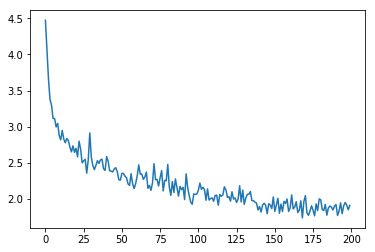

In [76]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.


In [81]:
'''We can see the effects of this by adjusting the temperature argument.'''
print(evaluate('Th', 200, temperature=0.8))

Thansignex whicer.ing times aldion buffer pamems modif
	.hid on the struct the iduer perifierrate on returt andbe
 *  (!inulap_n(struct bels)
		struct const prater_RACEN_CHZ_CEURG_STITE_FEG_MO_PAP


In [78]:
'''Lower temperatures are less varied, choosing only the more probable outputs:'''
print(evaluate('Th', 200, temperature=0.2))

Thend the contimer the canline the struct the contimer the the struct the calle the can int return int return int return int int reset the struct the contime the chare the contime the proup the contimer


In [79]:
''' Higher temperatures more varied, choosing less probable outputs:'''
print(evaluate('Th', 200, temperature=1.4))

Thlinoll\' shroutHen fs)4: stow-ctio en. infryysp,
, owdep *SFIRA
	.otrR) !dibd_wb#ap_blic
 * topt)+; */

#linct "P addshring fist it = n--unifn[ANZ)
{
}
'rlsevprej";) prot ttiffdef e!abemyPX

